# Tutorial: data integration for unpaired BMMC data

In this tutorial, we demonstrate how to apply FGOT to integrate unpaired BMMC data. The original dataset can be download from GSE159417. After preprocessing, the data used in this experiment can be downloaded from the website (https://drive.google.com/drive/folders/1ku9yfdUI1AExC-GflzEkU_F5bb8mbJ_f). 

## load package

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import scanpy as sc
from anndata import AnnData
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [14]:
import sys
sys.path.insert(1, '/home/nas2/biod/yangchenghui/FGOT-master')
import FGOT
from FGOT import preprocess as pre
from FGOT import fgot_sparse_tensor, fgot_tol, align
from FGOT import metrics as mt

## load data

In [15]:
data_path = "/home/nas2/biod/yangchenghui/FGOT-master/data/BMMC_data/"
RNA_data = pd.read_csv(data_path+'RNA_normalized.txt', sep='\t', index_col=0)
ATAC_data = pd.read_csv(data_path+'ATAC_normalized.txt', sep='\t', index_col=0)

In [16]:
RNA_cluster = pd.read_csv(data_path+"BMMC_RNA_label.txt", sep='\t')
ATAC_cluster = pd.read_csv(data_path+"BMMC_agg_k5_atac_label.txt", sep='\t')
RNA_cluster = RNA_cluster.reset_index()
RNA_cluster = RNA_cluster.rename(columns={'index':'cell','x': 'cluster'})
ATAC_cluster = ATAC_cluster.reset_index()
ATAC_cluster = ATAC_cluster.rename(columns={'index':'cell','metas': 'cluster'})

In [17]:
X1 = ATAC_data
X2 = RNA_data
(n1, d1) = X1.shape
(n2, d2) = X2.shape
print("Dimensions of input datasets are: ", "X1 = ", X1.shape, " X2 = ", X2.shape)
basic_labels1 = np.array(ATAC_cluster['cluster'])
basic_labels2 = np.array(RNA_cluster['cluster'])
print("Dimensions of basic_labels are: ", "basic_labels1 = ", basic_labels1.shape, " basic_labels2 = ", basic_labels2.shape)
cell_names1 = list(ATAC_data.index)
cell_names2 = list(RNA_data.index)
peak_names = list(ATAC_data.columns)
gene_names = list(RNA_data.columns)

Dimensions of input datasets are:  X1 =  (1602, 6970)  X2 =  (2379, 275)
Dimensions of basic_labels are:  basic_labels1 =  (1602,)  basic_labels2 =  (2379,)


## build a priori feature graph

In [18]:
promoters = pd.read_csv(data_path+'hg19.promoter.regions.txt', sep = '\t',header=None)
promoters[3] = promoters[3].str.split('|').str[0]
promoters.rename(columns={0: 'chr', 1: 'starts', 2: 'ends', 3: 'genes'}, inplace=True)
promoters.head()

,chr,starts,ends,genes
0,chr1,11869,11870,DDX11L1
1,chr1,11872,11873,DDX11L1
2,chr1,11874,11875,DDX11L1
3,chr1,12010,12011,DDX11L1
4,chr1,24886,24887,WASH7P


In [19]:
feature_matrix = pre.prior_feature_graph(promoters, peak_names, gene_names)
feature_matrix

0it [00:00, ?it/s]

178865it [00:00, 249301.97it/s]
178865it [00:03, 57021.02it/s]
100%|██████████| 275/275 [00:00<00:00, 448.14it/s]


The number of gene nodes, peak nodes, and edges in the prior feature graph is: 275 6970 8808


100%|██████████| 8808/8808 [00:00<00:00, 1939389.45it/s]


,TNFRSF25,EFHD2,RCAN3,LDLRAP1,STMN1,JUN,RHOC,CD2,CD160,MCL1,...,CLIC3,AP1S2,SAT1,CFP,PIM2,ALAS2,ITM2A,SH2D1A,CD40LG,MPP1
chr19-36400046-36400793,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr1-167479681-167479740,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr22-23062530-23064843,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr5-131720959-131721533,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr12-122326159-122327317,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr14-75760332-75763216,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr19-2819497-2820437,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr1-151893976-151894426,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr17-76272306-76272944,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


## compute cost across modalities

Calculate the similarity between cells through MNN pairs between embedding RNA and gene activity score from scVI.

In [20]:
S_m = pd.read_table(data_path+'cell_Cor_scVIlatent.txt',index_col=0).T
S_m

,AAACCTGAGCTTTGGT.1,AAACCTGCACAGGCCT.1,AAACCTGCATGCCTTC.1,AAACCTGGTGTGTGCC.1,AAACCTGTCCGTCATC.1,AAACGGGAGCTCCTCT.1,AAACGGGCACAAGTAA.1,AAACGGGCACATCCGG.1,AAACGGGCAGTGGGAT.1,AAACGGGGTAGGACAC.1,...,TTTGGTTAGGCCCGTT.1,TTTGGTTGTCAGTGGA.1,TTTGGTTGTGCCTGCA.1,TTTGGTTGTGTCTGAT.1,TTTGTCAAGAGTAAGG.1,TTTGTCAAGCCCAATT.1,TTTGTCAAGTCACGCC.1,TTTGTCACACATCCAA.1,TTTGTCACAGGTCTCG.1,TTTGTCATCGTAGGAG.1
Agg_atac_1-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Agg_atac_2-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Agg_atac_3-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Agg_atac_4-1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Agg_atac_5-1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Agg_atac_1598-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Agg_atac_1599-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Agg_atac_1600-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Agg_atac_1601-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# import snn
snn1 = pd.read_csv(data_path+"BMMC_atac_gene_acitivity_snn_k5.txt", sep='\t',index_col=0)
snn2 = pd.read_csv(data_path+"BMMC_rna_snn.txt", sep='\t',index_col=0)

In [22]:
S_sm = pre.smooth_cell_similarity_byLaplacian2(S_m,snn1,snn2)
S = S_sm/np.max(S_sm) + S_m/np.max(S_m)

In [23]:
# compute cost
cost = np.array(np.exp(np.max(S) - S))
cost = cost - np.min(cost)
cost = pd.DataFrame(cost, index = cell_names1, columns=cell_names2)

Text(0.5, 1.0, 'cost across modality')

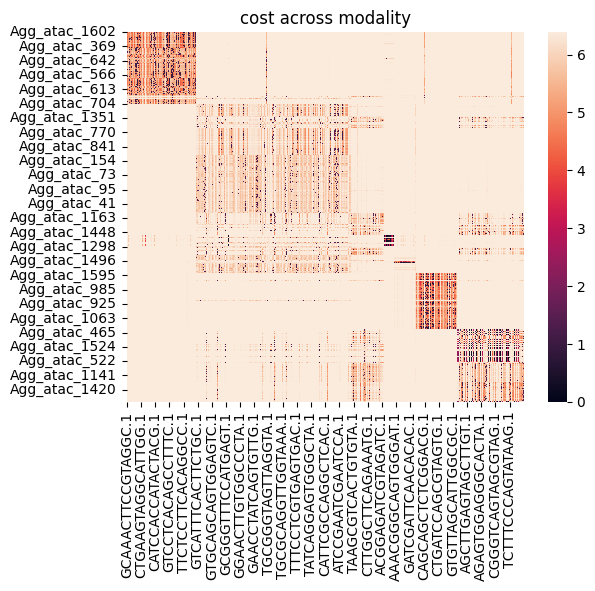

In [24]:
sorted_cols = np.argsort(basic_labels1)
sorted_cost = cost.iloc[sorted_cols,: ]
sorted_rows = np.argsort(basic_labels2)
sorted_cost = sorted_cost.iloc[:, sorted_rows]
sns.heatmap(sorted_cost)
pl.title('cost across modality')

## scale

In [25]:
scaler = StandardScaler()
X1, X2 = scaler.fit_transform(X1), scaler.fit_transform(X2)
X1 = pd.DataFrame(X1,index= cell_names1,columns=peak_names)
X2 = pd.DataFrame(X2,index= cell_names2,columns=gene_names)

## solve the feature-guided optimal transport problem

In [26]:
P_tensor = fgot_sparse_tensor(X1, X2, feature_matrix, cost, ATAC_cluster, RNA_cluster,\
    minibatch=1, batchsize=500, device='cuda:1',eps_p = 4e-2, rho_mu=100, rho_nu=100)

minibatch = 1 and device =  cuda:1
the total number of computing batch is  12


100%|██████████| 12/12 [1:22:42<00:00, 413.54s/it]


## make multi-omics alignment from the transport tensor

In [27]:
P = fgot_tol(P_tensor)
P.shape

100%|██████████| 8808/8808 [04:18<00:00, 34.07it/s] 


(1602, 2379)

Text(0.5, 1.0, 'optimal transport matrix')

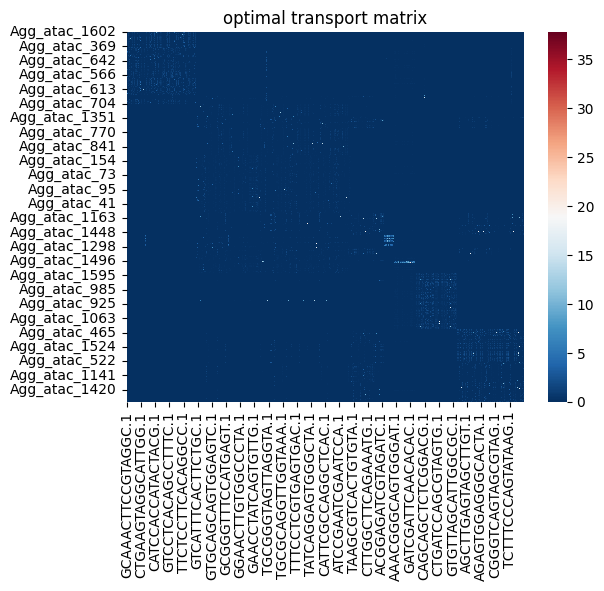

In [28]:
P_df = pd.DataFrame(P, index = cell_names1, columns = cell_names2)
sorted_cols = np.argsort(basic_labels1)
sorted_P = P_df.iloc[sorted_cols,: ]
sorted_rows = np.argsort(basic_labels2)
sorted_P = sorted_P.iloc[:, sorted_rows]
sns.heatmap(sorted_P, cmap="RdBu_r")
pl.title('optimal transport matrix')

In [29]:
X1_aligned, X2_aligned = align(X1, X2, P)

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterp

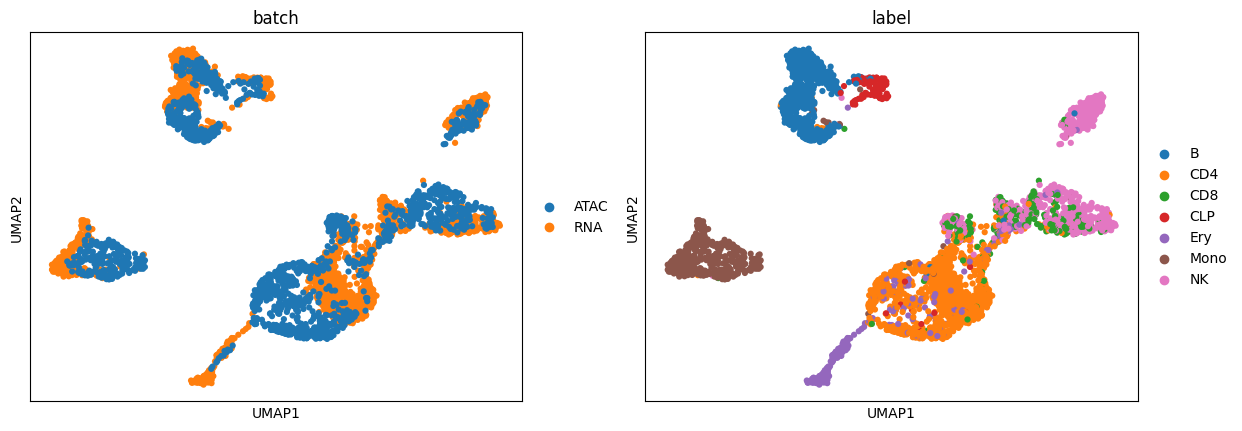

In [30]:
data_aligned = np.concatenate((X2_aligned, X1_aligned), axis=0)
adata_aligned = AnnData(data_aligned)
adata_aligned.obs['batch'] = np.array(['RNA'] * n2 + ['ATAC'] * n1)
adata_aligned.obs['label'] = np.concatenate((basic_labels2, basic_labels1),axis=0)
sc.tl.pca(adata_aligned)
sc.pp.neighbors(adata_aligned, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_aligned)
sc.pl.umap(adata_aligned, color=['batch','label'],s = 80)

## infer the cell type specific regulatory intensity from the transport tensor

In [31]:
intensity_df = FGOT.fgot.fgot_analysis_link_intensity_for_each_celltype(P_tensor, feature_matrix, basic_labels1, basic_labels2, mode = 'ATAC2RNA')
intensity_df

  0%|          | 0/275 [00:00<?, ?it/s]

100%|██████████| 275/275 [14:53<00:00,  3.25s/it]


,NK,Mono,B,CD4,CLP,CD8,Ery
HCST-chr19-36400046-36400793,0.000002,0.000077,4.277666e-06,1.734356e-06,6.603668e-05,0.000003,0.000000e+00
HCST-chr19-36504691-36505810,0.000027,0.000002,2.230071e-06,2.328561e-05,1.641800e-05,0.000027,7.940821e-06
HCST-chr19-36359168-36359710,0.000054,0.000015,8.413162e-07,1.521374e-05,4.422678e-06,0.000060,1.450530e-06
HCST-chr19-36238964-36239992,0.000035,0.000001,2.276394e-06,2.203324e-05,1.381136e-05,0.000031,3.365037e-05
HCST-chr19-36246426-36246837,0.000014,0.000021,1.182004e-06,1.754489e-05,5.492534e-06,0.000021,9.989417e-07
...,...,...,...,...,...,...,...
SNCA-chr4-90822975-90823353,0.000006,0.000027,8.328378e-06,2.136200e-06,2.644587e-05,0.000000,5.185541e-04
SNCA-chr4-90850760-90851251,0.000004,0.000003,1.106373e-06,5.761582e-06,1.329320e-14,0.000004,5.323828e-04
GYPB-chr4-144695106-144695549,0.000000,0.000000,1.935823e-05,8.209781e-06,5.710983e-04,0.000000,1.329234e-03
GYPB-chr4-144833188-144833444,0.000000,0.000000,4.059823e-25,1.546616e-09,1.253510e-05,0.000000,0.000000e+00


## solve the feature-guided optimal transport problem by an anchor-based minibatch strategy

In [19]:
P_anchor = FGOT.fgot.transfer_anchor(X1, X2, feature_matrix, cost, \
    ATAC_cluster, RNA_cluster, pair=False, mnn=S_m,\
    minibatch=1, batchsize = 500, device='cuda:1', eps_p=4e-2, rho_mu=100, rho_nu=100, q_cutoff=0.98)
P_anchor

Identify (1093, 940) anchor cells!
minibatch = 1 and device =  cuda:1
the total number of computing batch is  2


100%|██████████| 8808/8808 [00:09<00:00, 890.00it/s]


,TCGCGTTAGCGCCTCA.1,TCGCGTTCACCTCGGA.1,AAACCTGCATGCCTTC.1,TCGCGTTGTCGGATCC.1,TCGCGTTCATGCAACT.1,TCGCGTTTCACTTACT.1,AAACGGGCACATCCGG.1,TCGGGACCAGCCACCA.1,AAACGGGGTAGGACAC.1,TCGGGACCAGCTGCTG.1,...,TCATTTGCATCGGACC.1,TCATTTGGTACCGTAT.1,TCCACACCAAATTGCC.1,TCCCGATCACTAGTAC.1,TCCCGATGTGCCTTGG.1,TCCCGATTCGGCGGTT.1,TCGAGGCGTCGACTGC.1,TCGCGAGCAAGACACG.1,TCGCGAGCATGTAAGA.1,TCGCGAGCATTTCACT.1
Agg_atac_1,0.008761,1.060484e+00,7.840658e-08,9.260066e-01,0.016225,0.001043,0.025768,6.633345e-08,0.036170,0.028715,...,2.076093e-08,0.014835,0.020769,0.001867,5.093774e-08,1.078107e-08,0.008652,0.001706,0.012418,0.001850
Agg_atac_3,0.013090,7.199744e-08,3.601255e-07,2.291515e-08,0.027308,0.004193,0.026308,4.630581e-08,0.016374,0.020622,...,4.803090e-09,0.005950,0.014374,0.003623,1.804353e-06,2.164954e-08,0.019910,0.000213,0.006527,0.006609
Agg_atac_4,0.013506,9.471441e-08,1.276660e-07,6.940868e-08,0.022277,0.001929,0.024519,7.254178e-08,0.017475,0.018351,...,1.312741e-08,0.007479,0.013509,0.003177,5.757438e-08,1.095981e-08,0.012850,0.000249,0.007363,0.005074
Agg_atac_5,0.010487,9.019041e-01,1.391990e+00,7.485564e-01,0.010383,0.000120,0.024554,7.796505e-08,0.027075,0.023474,...,2.764662e-01,0.005621,0.020403,0.000903,6.961568e-08,9.327602e-09,0.005514,0.000508,0.006754,0.001047
Agg_atac_6,0.010576,2.827079e-08,1.472425e-08,7.169584e-01,0.015989,0.001810,0.036461,1.454718e-08,0.029676,0.025964,...,7.092149e-01,0.005664,0.018486,0.001909,1.487443e-08,2.038267e-08,0.009761,0.001629,0.013096,0.002189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Agg_atac_1590,1.600694,1.932049e-09,4.022737e-09,1.447458e-09,1.616288,0.004664,0.005658,3.027802e-09,0.009424,0.004668,...,1.216748e-09,0.003426,0.005112,0.002048,4.170373e-09,1.252238e-09,1.959119,0.000130,0.001501,0.005064
Agg_atac_1591,0.000047,2.970346e-09,3.650295e-09,1.854264e-09,2.613527,0.000746,0.004958,2.834305e-09,0.013681,0.006988,...,1.307487e-09,0.001805,0.005503,0.000864,4.394476e-09,1.182354e-09,0.000017,0.001157,0.002674,0.000800
Agg_atac_1593,3.287618,2.816760e-09,4.228006e-09,2.001917e-09,2.514706,0.001217,0.006809,2.570717e-09,0.007568,0.002900,...,1.354682e-09,0.002331,0.003273,0.001292,4.305473e-09,9.859025e-10,0.000011,0.001307,0.002036,0.001528
Agg_atac_1594,2.512159,2.007791e-09,1.021542e-04,7.561643e-05,2.185189,0.002079,0.004869,3.093345e-09,0.007624,0.003480,...,1.297708e-09,0.001980,0.003544,0.001167,6.400520e-07,2.643315e-07,2.250249,0.000086,0.001211,0.001469


In [20]:
P_tensor = fgot_sparse_tensor(X1, X2, feature_matrix, cost, ATAC_cluster, RNA_cluster,\
    minibatch=1, batchsize=500, device='cuda:1', eps_p = 4e-2, rho_mu=100, rho_nu=100, \
    fastMinibatch=False, P_anchor=P_anchor)

minibatch = 1 and device =  cuda:1
the total number of computing batch is  12


100%|██████████| 12/12 [1:16:14<00:00, 381.19s/it]


## make multi-omics alignment from the transport tensor

In [21]:
P = fgot_tol(P_tensor)
P.shape

100%|██████████| 8808/8808 [01:14<00:00, 117.53it/s]


(1602, 2379)

Text(0.5, 1.0, 'optimal transport matrix')

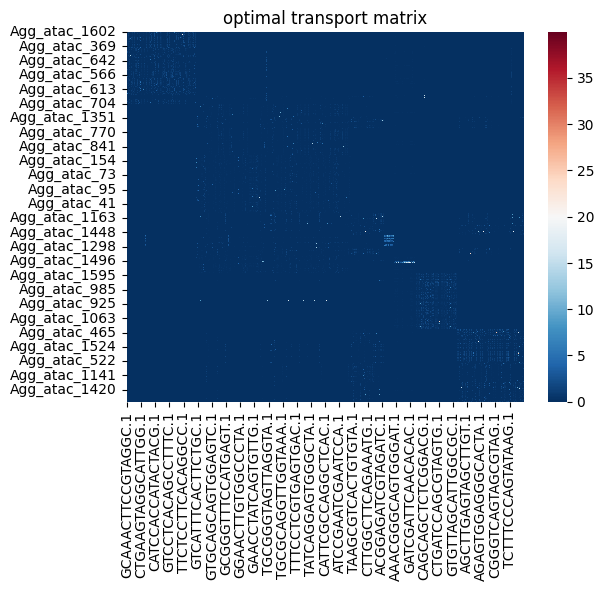

In [22]:
P_df = pd.DataFrame(P, index = cell_names1, columns = cell_names2)
sorted_cols = np.argsort(basic_labels1)
sorted_P = P_df.iloc[sorted_cols,: ]
sorted_rows = np.argsort(basic_labels2)
sorted_P = sorted_P.iloc[:, sorted_rows]
sns.heatmap(sorted_P, cmap="RdBu_r")
pl.title('optimal transport matrix')

In [23]:
X1_aligned, X2_aligned = align(X1, X2, P)

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Cat

[<Axes: title={'center': 'batch'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'label'}, xlabel='UMAP1', ylabel='UMAP2'>]

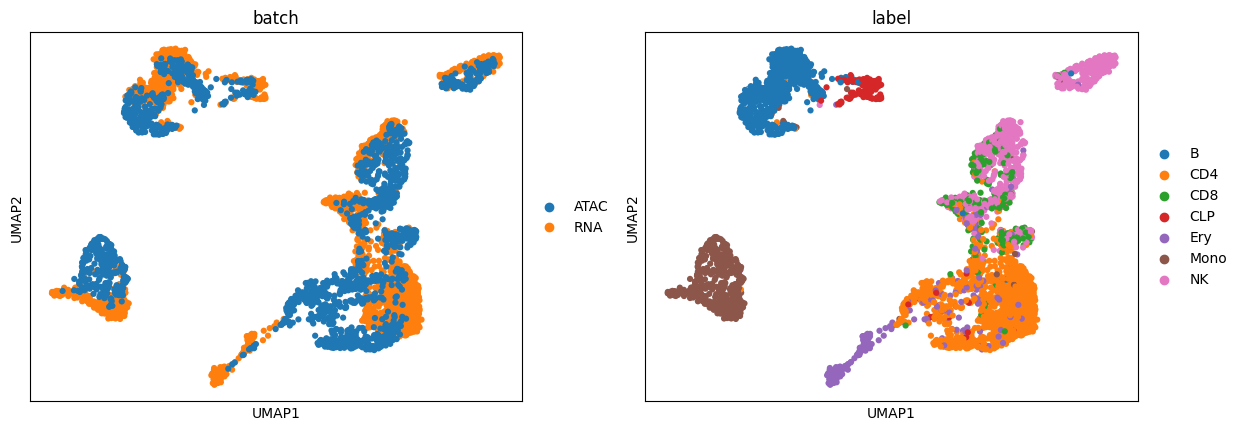

In [24]:
data_aligned = np.concatenate((X2_aligned, X1_aligned), axis=0)
adata_aligned = AnnData(data_aligned)
adata_aligned.obs['batch'] = np.array(['RNA'] * n2 + ['ATAC'] * n1)
adata_aligned.obs['label'] = np.concatenate((basic_labels2, basic_labels1),axis=0)
sc.tl.pca(adata_aligned)
sc.pp.neighbors(adata_aligned, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_aligned)
sc.pl.umap(adata_aligned, color=['batch', 'label'],s = 80, show=False)